## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 32
CROP_SIZE = 256
Z_START = 24
Z_DIMS = 16
TRAIN_FRAGMENTS = ["2", "3"]
TEST_FRAGMENT = "1"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

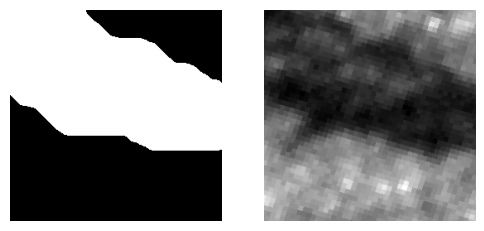

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4093

### Dataloaders

In [8]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 0]
                    if np.sum(surface) / (CROP_SIZE * CROP_SIZE) > 0.2:
                        self.xys.append((fragment, x, y, W, H))
        
        self.train_aug_list = [
                # A.RandomResizedCrop(
                #     size, size, scale=(0.85, 1.0)),
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                # A.RandomBrightnessContrast(p=0.75),
                A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(CROP_SIZE * 0.1), 
                                mask_fill_value=0, p=0.5),
                # A.ShiftScaleRotate(p=0.75),
                
                A.Rotate(limit=90, p=0.9), 
                
                # A.OneOf([
                #         A.GaussNoise(var_limit=[0.01, 0.05]),
                #         A.GaussianBlur(blur_limit=(3, 5), sigma_limit=0),
                #         A.MotionBlur(blur_limit=3),
                #         ], p=0.8),
                # A.GridDistortion(num_steps=1, distort_limit=0.1, p=0.5),
                # A.MultiplicativeNoise(per_channel=True, multiplier=(0.95, 1.05)),
                
                # A.Cutout(max_h_size=int(CROP_SIZE * 0.2),
                #          max_w_size=int(CROP_SIZE * 0.2), num_holes=1, p=1.0),
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-128 if x1 != 0 else 0, 128)
        y_offset = random.randint(-128 if y1 != 0 else 0, 128)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/65535.0
        
        
        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.unsqueeze(0) 
        mask_crop = mask_crop.float().unsqueeze(0)
        
        
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [10]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        # frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [11]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

In [12]:
i = random.randint(0, len(dataset_train))
i=30
img = dataset_train[i][0]
img.min(), img.max()

(tensor(0., dtype=torch.float64), tensor(0.9980, dtype=torch.float64))

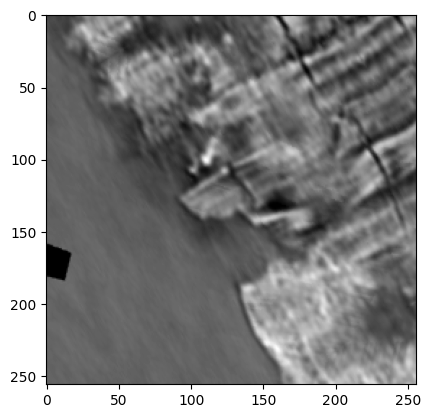

In [13]:
img_2 = img.squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(img_2[:, :, 0], cmap="gray")

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [14]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=34, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [15]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0])

model = model.cuda()

_IncompatibleKeys(missing_keys=['layer1.2.conv1.weight', 'layer1.2.bn1.weight', 'layer1.2.bn1.bias', 'layer1.2.bn1.running_mean', 'layer1.2.bn1.running_var', 'layer1.2.conv2.weight', 'layer1.2.bn2.weight', 'layer1.2.bn2.bias', 'layer1.2.bn2.running_mean', 'layer1.2.bn2.running_var', 'layer2.2.conv1.weight', 'layer2.2.bn1.weight', 'layer2.2.bn1.bias', 'layer2.2.bn1.running_mean', 'layer2.2.bn1.running_var', 'layer2.2.conv2.weight', 'layer2.2.bn2.weight', 'layer2.2.bn2.bias', 'layer2.2.bn2.running_mean', 'layer2.2.bn2.running_var', 'layer2.3.conv1.weight', 'layer2.3.bn1.weight', 'layer2.3.bn1.bias', 'layer2.3.bn1.running_mean', 'layer2.3.bn1.running_var', 'layer2.3.conv2.weight', 'layer2.3.bn2.weight', 'layer2.3.bn2.bias', 'layer2.3.bn2.running_mean', 'layer2.3.bn2.running_var', 'layer3.2.conv1.weight', 'layer3.2.bn1.weight', 'layer3.2.bn1.bias', 'layer3.2.bn1.running_mean', 'layer3.2.bn1.running_var', 'layer3.2.conv2.weight', 'layer3.2.bn2.weight', 'layer3.2.bn2.bias', 'layer3.2.bn2.run

In [16]:
x = torch.randn(5, 1, 16, 256, 256).cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Competition metric (F0.5 Score)

In [17]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [18]:
scaler = amp.GradScaler()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=10, epochs=EPOCHS//10,
                                                pct_start=0.1)

In [19]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [20]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [21]:
fbeta_best = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    for threshold in np.arange(0.2, 0.85, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best_{fbeta_best:.4f}.pt")
    
    
    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")

    # if epoch == 30:
    #     break

    print()

Epoch 1/50  Mem : 17.5GB  LR : 4.00E-06  Loss: 0.6652: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]                                                                                                                                                                           
Val Loss: 0.6775: 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.133450
Threshold : 0.25	FBeta : 0.135163
Threshold : 0.30	FBeta : 0.141194
Threshold : 0.35	FBeta : 0.152292
Threshold : 0.40	FBeta : 0.165090
Threshold : 0.45	FBeta : 0.172862
Threshold : 0.50	FBeta : 0.149327
Threshold : 0.55	FBeta : 0.075354
Threshold : 0.60	FBeta : 0.013948
Threshold : 0.65	FBeta : 0.000818
Threshold : 0.70	FBeta : 0.000004
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 2/50  Mem : 22GB  LR : 1.81E-05  Loss: 0.5864: 100%|██████████| 62/62 [00:38<00:00,  1.61it/s]                                                                                                                                                                             
Val Loss: 2.1243: 100%|██████████| 24/24 [00:07<00:00,  3.26it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.133296
Threshold : 0.25	FBeta : 0.135132
Threshold : 0.30	FBeta : 0.139019
Threshold : 0.35	FBeta : 0.144530
Threshold : 0.40	FBeta : 0.150209
Threshold : 0.45	FBeta : 0.149514
Threshold : 0.50	FBeta : 0.138429
Threshold : 0.55	FBeta : 0.102382
Threshold : 0.60	FBeta : 0.031463
Threshold : 0.65	FBeta : 0.000418
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 3/50  Mem : 22GB  LR : 5.20E-05  Loss: 0.5224: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]                                                                                                                                                                             
Val Loss: 0.3835: 100%|██████████| 24/24 [00:07<00:00,  3.26it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.201891
Threshold : 0.25	FBeta : 0.222986
Threshold : 0.30	FBeta : 0.236337
Threshold : 0.35	FBeta : 0.238457
Threshold : 0.40	FBeta : 0.148218
Threshold : 0.45	FBeta : 0.007189
Threshold : 0.50	FBeta : 0.000003
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 4/50  Mem : 22GB  LR : 8.59E-05  Loss: 0.4915: 100%|██████████| 62/62 [00:38<00:00,  1.61it/s]                                                                                                                                                                             
Val Loss: 1.7911: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.174808
Threshold : 0.25	FBeta : 0.191542
Threshold : 0.30	FBeta : 0.204118
Threshold : 0.35	FBeta : 0.212265
Threshold : 0.40	FBeta : 0.204366
Threshold : 0.45	FBeta : 0.169617
Threshold : 0.50	FBeta : 0.081649
Threshold : 0.55	FBeta : 0.003702
Threshold : 0.60	FBeta : 0.000705
Threshold : 0.65	FBeta : 0.000224
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 5/50  Mem : 22GB  LR : 1.00E-04  Loss: 0.4683: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]                                                                                                                                                                             
Val Loss: 0.8450: 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.191084
Threshold : 0.25	FBeta : 0.204712
Threshold : 0.30	FBeta : 0.207502
Threshold : 0.35	FBeta : 0.116340
Threshold : 0.40	FBeta : 0.008685
Threshold : 0.45	FBeta : 0.000000
Threshold : 0.50	FBeta : 0.000000
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 6/50  Mem : 22GB  LR : 9.99E-05  Loss: 0.4535: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]                                                                                                                                                                             
Val Loss: 0.3428: 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.234647
Threshold : 0.25	FBeta : 0.297059
Threshold : 0.30	FBeta : 0.329784
Threshold : 0.35	FBeta : 0.286982
Threshold : 0.40	FBeta : 0.203054
Threshold : 0.45	FBeta : 0.122365
Threshold : 0.50	FBeta : 0.060894
Threshold : 0.55	FBeta : 0.006198
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 7/50  Mem : 22GB  LR : 9.95E-05  Loss: 0.4356: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]                                                                                                                                                                             
Val Loss: 0.3265: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]                                                                                                                                                                                                                

Threshold : 0.20	FBeta : 0.237157
Threshold : 0.25	FBeta : 0.249642
Threshold : 0.30	FBeta : 0.263281
Threshold : 0.35	FBeta : 0.226935
Threshold : 0.40	FBeta : 0.110765
Threshold : 0.45	FBeta : 0.043606
Threshold : 0.50	FBeta : 0.005884
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000




Epoch 8/50  Mem : 22GB  LR : 9.89E-05  Loss: 0.4154: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]                                                                                                                                                                             
Val Loss: 0.4064: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.247575
Threshold : 0.25	FBeta : 0.285370
Threshold : 0.30	FBeta : 0.260350
Threshold : 0.35	FBeta : 0.234310
Threshold : 0.40	FBeta : 0.209070
Threshold : 0.45	FBeta : 0.181401
Threshold : 0.50	FBeta : 0.152086
Threshold : 0.55	FBeta : 0.109823
Threshold : 0.60	FBeta : 0.043505
Threshold : 0.65	FBeta : 0.003212
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 9/50  Mem : 22GB  LR : 9.81E-05  Loss: 0.3993: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]                                                                                                                                                                             
Val Loss: 0.3157: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.281752
Threshold : 0.25	FBeta : 0.296478
Threshold : 0.30	FBeta : 0.297055
Threshold : 0.35	FBeta : 0.291965
Threshold : 0.40	FBeta : 0.283459
Threshold : 0.45	FBeta : 0.271808
Threshold : 0.50	FBeta : 0.254905
Threshold : 0.55	FBeta : 0.216357
Threshold : 0.60	FBeta : 0.147466
Threshold : 0.65	FBeta : 0.062946
Threshold : 0.70	FBeta : 0.013917
Threshold : 0.75	FBeta : 0.000075
Threshold : 0.80	FBeta : 0.000000



Epoch 10/50  Mem : 22GB  LR : 9.70E-05  Loss: 0.3836: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.4106: 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.264267
Threshold : 0.25	FBeta : 0.285364
Threshold : 0.30	FBeta : 0.300734
Threshold : 0.35	FBeta : 0.313108
Threshold : 0.40	FBeta : 0.324359
Threshold : 0.45	FBeta : 0.336463
Threshold : 0.50	FBeta : 0.352632
Threshold : 0.55	FBeta : 0.376479
Threshold : 0.60	FBeta : 0.402539
Threshold : 0.65	FBeta : 0.427939
Threshold : 0.70	FBeta : 0.447187
Threshold : 0.75	FBeta : 0.457935
Threshold : 0.80	FBeta : 0.458665



Epoch 11/50  Mem : 22GB  LR : 9.57E-05  Loss: 0.3726: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]                                                                                                                                                                            
Val Loss: 0.2788: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.422763
Threshold : 0.25	FBeta : 0.452405
Threshold : 0.30	FBeta : 0.458474
Threshold : 0.35	FBeta : 0.447528
Threshold : 0.40	FBeta : 0.433145
Threshold : 0.45	FBeta : 0.411510
Threshold : 0.50	FBeta : 0.376605
Threshold : 0.55	FBeta : 0.331269
Threshold : 0.60	FBeta : 0.277462
Threshold : 0.65	FBeta : 0.223280
Threshold : 0.70	FBeta : 0.163823
Threshold : 0.75	FBeta : 0.107265
Threshold : 0.80	FBeta : 0.060050



Epoch 12/50  Mem : 22GB  LR : 9.41E-05  Loss: 0.3639: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]                                                                                                                                                                            
Val Loss: 0.4863: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.256921
Threshold : 0.25	FBeta : 0.264181
Threshold : 0.30	FBeta : 0.270860
Threshold : 0.35	FBeta : 0.276458
Threshold : 0.40	FBeta : 0.282801
Threshold : 0.45	FBeta : 0.291076
Threshold : 0.50	FBeta : 0.301775
Threshold : 0.55	FBeta : 0.316682
Threshold : 0.60	FBeta : 0.334785
Threshold : 0.65	FBeta : 0.352863
Threshold : 0.70	FBeta : 0.368428
Threshold : 0.75	FBeta : 0.382819
Threshold : 0.80	FBeta : 0.395575



Epoch 13/50  Mem : 22GB  LR : 9.24E-05  Loss: 0.3568: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]                                                                                                                                                                            
Val Loss: 0.2969: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.324966
Threshold : 0.25	FBeta : 0.341087
Threshold : 0.30	FBeta : 0.351759
Threshold : 0.35	FBeta : 0.358665
Threshold : 0.40	FBeta : 0.363822
Threshold : 0.45	FBeta : 0.367967
Threshold : 0.50	FBeta : 0.370878
Threshold : 0.55	FBeta : 0.368409
Threshold : 0.60	FBeta : 0.360778
Threshold : 0.65	FBeta : 0.348448
Threshold : 0.70	FBeta : 0.325468
Threshold : 0.75	FBeta : 0.292126
Threshold : 0.80	FBeta : 0.251957



Epoch 14/50  Mem : 22GB  LR : 9.05E-05  Loss: 0.3527: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2771: 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.386540
Threshold : 0.25	FBeta : 0.398907
Threshold : 0.30	FBeta : 0.407835
Threshold : 0.35	FBeta : 0.409704
Threshold : 0.40	FBeta : 0.407606
Threshold : 0.45	FBeta : 0.401835
Threshold : 0.50	FBeta : 0.381740
Threshold : 0.55	FBeta : 0.343117
Threshold : 0.60	FBeta : 0.293847
Threshold : 0.65	FBeta : 0.242606
Threshold : 0.70	FBeta : 0.191357
Threshold : 0.75	FBeta : 0.146743
Threshold : 0.80	FBeta : 0.104344



Epoch 15/50  Mem : 22GB  LR : 8.83E-05  Loss: 0.3400: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]                                                                                                                                                                            
Val Loss: 0.2724: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.337131
Threshold : 0.25	FBeta : 0.370503
Threshold : 0.30	FBeta : 0.393007
Threshold : 0.35	FBeta : 0.410849
Threshold : 0.40	FBeta : 0.427198
Threshold : 0.45	FBeta : 0.443239
Threshold : 0.50	FBeta : 0.457968
Threshold : 0.55	FBeta : 0.474139
Threshold : 0.60	FBeta : 0.480137
Threshold : 0.65	FBeta : 0.474523
Threshold : 0.70	FBeta : 0.457998
Threshold : 0.75	FBeta : 0.424933
Threshold : 0.80	FBeta : 0.372997



Epoch 16/50  Mem : 22GB  LR : 8.60E-05  Loss: 0.3363: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]                                                                                                                                                                            
Val Loss: 0.3416: 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.343236
Threshold : 0.25	FBeta : 0.361696
Threshold : 0.30	FBeta : 0.375835
Threshold : 0.35	FBeta : 0.387113
Threshold : 0.40	FBeta : 0.397675
Threshold : 0.45	FBeta : 0.408635
Threshold : 0.50	FBeta : 0.418433
Threshold : 0.55	FBeta : 0.428744
Threshold : 0.60	FBeta : 0.434884
Threshold : 0.65	FBeta : 0.435154
Threshold : 0.70	FBeta : 0.430735
Threshold : 0.75	FBeta : 0.421598
Threshold : 0.80	FBeta : 0.407112



Epoch 17/50  Mem : 22GB  LR : 8.35E-05  Loss: 0.3295: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2637: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.440348
Threshold : 0.25	FBeta : 0.456301
Threshold : 0.30	FBeta : 0.465469
Threshold : 0.35	FBeta : 0.471460
Threshold : 0.40	FBeta : 0.472742
Threshold : 0.45	FBeta : 0.471467
Threshold : 0.50	FBeta : 0.472699
Threshold : 0.55	FBeta : 0.476020
Threshold : 0.60	FBeta : 0.474271
Threshold : 0.65	FBeta : 0.464917
Threshold : 0.70	FBeta : 0.445961
Threshold : 0.75	FBeta : 0.416075
Threshold : 0.80	FBeta : 0.379063



Epoch 18/50  Mem : 22GB  LR : 8.08E-05  Loss: 0.3288: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]                                                                                                                                                                            
Val Loss: 0.6117: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.270984
Threshold : 0.25	FBeta : 0.279889
Threshold : 0.30	FBeta : 0.287516
Threshold : 0.35	FBeta : 0.294731
Threshold : 0.40	FBeta : 0.301158
Threshold : 0.45	FBeta : 0.307957
Threshold : 0.50	FBeta : 0.316753
Threshold : 0.55	FBeta : 0.329042
Threshold : 0.60	FBeta : 0.342653
Threshold : 0.65	FBeta : 0.356296
Threshold : 0.70	FBeta : 0.371014
Threshold : 0.75	FBeta : 0.385795
Threshold : 0.80	FBeta : 0.399834



Epoch 19/50  Mem : 22GB  LR : 7.80E-05  Loss: 0.3149: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.3263: 100%|██████████| 24/24 [00:07<00:00,  3.32it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.314269
Threshold : 0.25	FBeta : 0.326643
Threshold : 0.30	FBeta : 0.336196
Threshold : 0.35	FBeta : 0.347625
Threshold : 0.40	FBeta : 0.360288
Threshold : 0.45	FBeta : 0.373843
Threshold : 0.50	FBeta : 0.390364
Threshold : 0.55	FBeta : 0.408341
Threshold : 0.60	FBeta : 0.424427
Threshold : 0.65	FBeta : 0.438415
Threshold : 0.70	FBeta : 0.449869
Threshold : 0.75	FBeta : 0.459000
Threshold : 0.80	FBeta : 0.457902



Epoch 20/50  Mem : 22GB  LR : 7.50E-05  Loss: 0.3076: 100%|██████████| 62/62 [00:38<00:00,  1.61it/s]                                                                                                                                                                            
Val Loss: 0.2581: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.342329
Threshold : 0.25	FBeta : 0.367876
Threshold : 0.30	FBeta : 0.387395
Threshold : 0.35	FBeta : 0.403884
Threshold : 0.40	FBeta : 0.420967
Threshold : 0.45	FBeta : 0.438182
Threshold : 0.50	FBeta : 0.462232
Threshold : 0.55	FBeta : 0.478208
Threshold : 0.60	FBeta : 0.477250
Threshold : 0.65	FBeta : 0.455482
Threshold : 0.70	FBeta : 0.421106
Threshold : 0.75	FBeta : 0.372141
Threshold : 0.80	FBeta : 0.297306



Epoch 21/50  Mem : 22GB  LR : 7.19E-05  Loss: 0.3119: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2842: 100%|██████████| 24/24 [00:07<00:00,  3.32it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.314384
Threshold : 0.25	FBeta : 0.335233
Threshold : 0.30	FBeta : 0.356972
Threshold : 0.35	FBeta : 0.380053
Threshold : 0.40	FBeta : 0.405841
Threshold : 0.45	FBeta : 0.427819
Threshold : 0.50	FBeta : 0.455487
Threshold : 0.55	FBeta : 0.478827
Threshold : 0.60	FBeta : 0.494266
Threshold : 0.65	FBeta : 0.507344
Threshold : 0.70	FBeta : 0.510626
Threshold : 0.75	FBeta : 0.502807
Threshold : 0.80	FBeta : 0.476185



Epoch 22/50  Mem : 22GB  LR : 6.87E-05  Loss: 0.3110: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2454: 100%|██████████| 24/24 [00:07<00:00,  3.27it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.438593
Threshold : 0.25	FBeta : 0.459520
Threshold : 0.30	FBeta : 0.474908
Threshold : 0.35	FBeta : 0.485502
Threshold : 0.40	FBeta : 0.492705
Threshold : 0.45	FBeta : 0.494545
Threshold : 0.50	FBeta : 0.495092
Threshold : 0.55	FBeta : 0.484868
Threshold : 0.60	FBeta : 0.460376
Threshold : 0.65	FBeta : 0.425395
Threshold : 0.70	FBeta : 0.385409
Threshold : 0.75	FBeta : 0.333453
Threshold : 0.80	FBeta : 0.271622



Epoch 23/50  Mem : 22GB  LR : 6.55E-05  Loss: 0.2974: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]                                                                                                                                                                            
Val Loss: 0.2752: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.367366
Threshold : 0.25	FBeta : 0.393220
Threshold : 0.30	FBeta : 0.414573
Threshold : 0.35	FBeta : 0.434502
Threshold : 0.40	FBeta : 0.450353
Threshold : 0.45	FBeta : 0.464456
Threshold : 0.50	FBeta : 0.477277
Threshold : 0.55	FBeta : 0.492462
Threshold : 0.60	FBeta : 0.505213
Threshold : 0.65	FBeta : 0.514507
Threshold : 0.70	FBeta : 0.521664
Threshold : 0.75	FBeta : 0.524816
Threshold : 0.80	FBeta : 0.522794



Epoch 24/50  Mem : 22GB  LR : 6.21E-05  Loss: 0.2975: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2599: 100%|██████████| 24/24 [00:07<00:00,  3.28it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.489824
Threshold : 0.25	FBeta : 0.493257
Threshold : 0.30	FBeta : 0.490223
Threshold : 0.35	FBeta : 0.483757
Threshold : 0.40	FBeta : 0.476959
Threshold : 0.45	FBeta : 0.465274
Threshold : 0.50	FBeta : 0.448226
Threshold : 0.55	FBeta : 0.423536
Threshold : 0.60	FBeta : 0.391527
Threshold : 0.65	FBeta : 0.350787
Threshold : 0.70	FBeta : 0.303930
Threshold : 0.75	FBeta : 0.249407
Threshold : 0.80	FBeta : 0.187010



Epoch 25/50  Mem : 22GB  LR : 5.87E-05  Loss: 0.3020: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]                                                                                                                                                                            
Val Loss: 0.2650: 100%|██████████| 24/24 [00:07<00:00,  3.32it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.352428
Threshold : 0.25	FBeta : 0.373922
Threshold : 0.30	FBeta : 0.394184
Threshold : 0.35	FBeta : 0.413305
Threshold : 0.40	FBeta : 0.432977
Threshold : 0.45	FBeta : 0.453331
Threshold : 0.50	FBeta : 0.476164
Threshold : 0.55	FBeta : 0.497867
Threshold : 0.60	FBeta : 0.516347
Threshold : 0.65	FBeta : 0.530499
Threshold : 0.70	FBeta : 0.538048
Threshold : 0.75	FBeta : 0.536898
Threshold : 0.80	FBeta : 0.525207



Epoch 26/50  Mem : 22GB  LR : 5.52E-05  Loss: 0.2957: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]                                                                                                                                                                            
Val Loss: 0.2713: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.502887
Threshold : 0.25	FBeta : 0.494639
Threshold : 0.30	FBeta : 0.484988
Threshold : 0.35	FBeta : 0.472288
Threshold : 0.40	FBeta : 0.457247
Threshold : 0.45	FBeta : 0.436626
Threshold : 0.50	FBeta : 0.412729
Threshold : 0.55	FBeta : 0.386730
Threshold : 0.60	FBeta : 0.353159
Threshold : 0.65	FBeta : 0.308316
Threshold : 0.70	FBeta : 0.253283
Threshold : 0.75	FBeta : 0.189761
Threshold : 0.80	FBeta : 0.120421



Epoch 27/50  Mem : 22GB  LR : 5.17E-05  Loss: 0.2899: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2496: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.509066
Threshold : 0.25	FBeta : 0.513023
Threshold : 0.30	FBeta : 0.512944
Threshold : 0.35	FBeta : 0.511521
Threshold : 0.40	FBeta : 0.497967
Threshold : 0.45	FBeta : 0.475538
Threshold : 0.50	FBeta : 0.452027
Threshold : 0.55	FBeta : 0.423921
Threshold : 0.60	FBeta : 0.389888
Threshold : 0.65	FBeta : 0.350009
Threshold : 0.70	FBeta : 0.299232
Threshold : 0.75	FBeta : 0.249046
Threshold : 0.80	FBeta : 0.205566



Epoch 28/50  Mem : 22GB  LR : 4.83E-05  Loss: 0.2861: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]                                                                                                                                                                            
Val Loss: 0.2796: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.339574
Threshold : 0.25	FBeta : 0.358049
Threshold : 0.30	FBeta : 0.374496
Threshold : 0.35	FBeta : 0.392267
Threshold : 0.40	FBeta : 0.410312
Threshold : 0.45	FBeta : 0.426327
Threshold : 0.50	FBeta : 0.444269
Threshold : 0.55	FBeta : 0.460152
Threshold : 0.60	FBeta : 0.474952
Threshold : 0.65	FBeta : 0.485145
Threshold : 0.70	FBeta : 0.491027
Threshold : 0.75	FBeta : 0.489698
Threshold : 0.80	FBeta : 0.478283



Epoch 29/50  Mem : 22GB  LR : 4.48E-05  Loss: 0.2819: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]                                                                                                                                                                            
Val Loss: 0.2682: 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.373082
Threshold : 0.25	FBeta : 0.392406
Threshold : 0.30	FBeta : 0.408615
Threshold : 0.35	FBeta : 0.424636
Threshold : 0.40	FBeta : 0.438829
Threshold : 0.45	FBeta : 0.453086
Threshold : 0.50	FBeta : 0.466863
Threshold : 0.55	FBeta : 0.480180
Threshold : 0.60	FBeta : 0.491537
Threshold : 0.65	FBeta : 0.499864
Threshold : 0.70	FBeta : 0.499280
Threshold : 0.75	FBeta : 0.491938
Threshold : 0.80	FBeta : 0.474592



Epoch 30/50  Mem : 22GB  LR : 4.13E-05  Loss: 0.2854: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]                                                                                                                                                                            
Val Loss: 0.2873: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.349696
Threshold : 0.25	FBeta : 0.369418
Threshold : 0.30	FBeta : 0.387219
Threshold : 0.35	FBeta : 0.403226
Threshold : 0.40	FBeta : 0.416934
Threshold : 0.45	FBeta : 0.429355
Threshold : 0.50	FBeta : 0.443418
Threshold : 0.55	FBeta : 0.457786
Threshold : 0.60	FBeta : 0.471384
Threshold : 0.65	FBeta : 0.481866
Threshold : 0.70	FBeta : 0.489207
Threshold : 0.75	FBeta : 0.491140
Threshold : 0.80	FBeta : 0.488603



Epoch 31/50  Mem : 22GB  LR : 3.79E-05  Loss: 0.2869: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]                                                                                                                                                                            
Val Loss: 0.2371: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.427075
Threshold : 0.25	FBeta : 0.448500
Threshold : 0.30	FBeta : 0.468370
Threshold : 0.35	FBeta : 0.484829
Threshold : 0.40	FBeta : 0.497321
Threshold : 0.45	FBeta : 0.505620
Threshold : 0.50	FBeta : 0.511786
Threshold : 0.55	FBeta : 0.517273
Threshold : 0.60	FBeta : 0.520163
Threshold : 0.65	FBeta : 0.516299
Threshold : 0.70	FBeta : 0.502226
Threshold : 0.75	FBeta : 0.473801
Threshold : 0.80	FBeta : 0.434556



Epoch 32/50  Mem : 22GB  LR : 3.45E-05  Loss: 0.2751: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2599: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.507252
Threshold : 0.25	FBeta : 0.509905
Threshold : 0.30	FBeta : 0.502302
Threshold : 0.35	FBeta : 0.492126
Threshold : 0.40	FBeta : 0.480529
Threshold : 0.45	FBeta : 0.470540
Threshold : 0.50	FBeta : 0.458621
Threshold : 0.55	FBeta : 0.444531
Threshold : 0.60	FBeta : 0.423757
Threshold : 0.65	FBeta : 0.392734
Threshold : 0.70	FBeta : 0.356046
Threshold : 0.75	FBeta : 0.311473
Threshold : 0.80	FBeta : 0.262692



Epoch 33/50  Mem : 22GB  LR : 3.13E-05  Loss: 0.2798: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2349: 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.477834
Threshold : 0.25	FBeta : 0.496630
Threshold : 0.30	FBeta : 0.510024
Threshold : 0.35	FBeta : 0.516591
Threshold : 0.40	FBeta : 0.519120
Threshold : 0.45	FBeta : 0.524315
Threshold : 0.50	FBeta : 0.520718
Threshold : 0.55	FBeta : 0.507156
Threshold : 0.60	FBeta : 0.486927
Threshold : 0.65	FBeta : 0.462809
Threshold : 0.70	FBeta : 0.429053
Threshold : 0.75	FBeta : 0.385093
Threshold : 0.80	FBeta : 0.328141



Epoch 34/50  Mem : 22GB  LR : 2.81E-05  Loss: 0.2726: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]                                                                                                                                                                            
Val Loss: 0.2334: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.492168
Threshold : 0.25	FBeta : 0.513835
Threshold : 0.30	FBeta : 0.528840
Threshold : 0.35	FBeta : 0.536138
Threshold : 0.40	FBeta : 0.539192
Threshold : 0.45	FBeta : 0.537401
Threshold : 0.50	FBeta : 0.532319
Threshold : 0.55	FBeta : 0.526287
Threshold : 0.60	FBeta : 0.513498
Threshold : 0.65	FBeta : 0.493752
Threshold : 0.70	FBeta : 0.461645
Threshold : 0.75	FBeta : 0.420463
Threshold : 0.80	FBeta : 0.364466



Epoch 35/50  Mem : 22GB  LR : 2.50E-05  Loss: 0.2745: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]                                                                                                                                                                            
Val Loss: 0.2858: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.334806
Threshold : 0.25	FBeta : 0.353237
Threshold : 0.30	FBeta : 0.368774
Threshold : 0.35	FBeta : 0.384672
Threshold : 0.40	FBeta : 0.400812
Threshold : 0.45	FBeta : 0.418540
Threshold : 0.50	FBeta : 0.440518
Threshold : 0.55	FBeta : 0.464119
Threshold : 0.60	FBeta : 0.480629
Threshold : 0.65	FBeta : 0.490089
Threshold : 0.70	FBeta : 0.493186
Threshold : 0.75	FBeta : 0.488283
Threshold : 0.80	FBeta : 0.475739



Epoch 36/50  Mem : 22GB  LR : 2.20E-05  Loss: 0.2746: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2291: 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.483718
Threshold : 0.25	FBeta : 0.508356
Threshold : 0.30	FBeta : 0.524395
Threshold : 0.35	FBeta : 0.536036
Threshold : 0.40	FBeta : 0.542720
Threshold : 0.45	FBeta : 0.545057
Threshold : 0.50	FBeta : 0.545386
Threshold : 0.55	FBeta : 0.541747
Threshold : 0.60	FBeta : 0.532883
Threshold : 0.65	FBeta : 0.521687
Threshold : 0.70	FBeta : 0.508327
Threshold : 0.75	FBeta : 0.488679
Threshold : 0.80	FBeta : 0.458355



Epoch 37/50  Mem : 22GB  LR : 1.92E-05  Loss: 0.2706: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2333: 100%|██████████| 24/24 [00:07<00:00,  3.28it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.508932
Threshold : 0.25	FBeta : 0.524070
Threshold : 0.30	FBeta : 0.533454
Threshold : 0.35	FBeta : 0.536228
Threshold : 0.40	FBeta : 0.535063
Threshold : 0.45	FBeta : 0.533803
Threshold : 0.50	FBeta : 0.528082
Threshold : 0.55	FBeta : 0.519488
Threshold : 0.60	FBeta : 0.508224
Threshold : 0.65	FBeta : 0.492438
Threshold : 0.70	FBeta : 0.472956
Threshold : 0.75	FBeta : 0.441988
Threshold : 0.80	FBeta : 0.394074



Epoch 38/50  Mem : 22GB  LR : 1.65E-05  Loss: 0.2689: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]                                                                                                                                                                            
Val Loss: 0.2284: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.494143
Threshold : 0.25	FBeta : 0.514707
Threshold : 0.30	FBeta : 0.527943
Threshold : 0.35	FBeta : 0.537312
Threshold : 0.40	FBeta : 0.542162
Threshold : 0.45	FBeta : 0.542499
Threshold : 0.50	FBeta : 0.538819
Threshold : 0.55	FBeta : 0.528155
Threshold : 0.60	FBeta : 0.515365
Threshold : 0.65	FBeta : 0.500310
Threshold : 0.70	FBeta : 0.477397
Threshold : 0.75	FBeta : 0.444804
Threshold : 0.80	FBeta : 0.400180



Epoch 39/50  Mem : 22GB  LR : 1.40E-05  Loss: 0.2657: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2264: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.514899
Threshold : 0.25	FBeta : 0.535998
Threshold : 0.30	FBeta : 0.551794
Threshold : 0.35	FBeta : 0.559922
Threshold : 0.40	FBeta : 0.557693
Threshold : 0.45	FBeta : 0.548567
Threshold : 0.50	FBeta : 0.534744
Threshold : 0.55	FBeta : 0.517357
Threshold : 0.60	FBeta : 0.494351
Threshold : 0.65	FBeta : 0.469067
Threshold : 0.70	FBeta : 0.438121
Threshold : 0.75	FBeta : 0.393959
Threshold : 0.80	FBeta : 0.336967



Epoch 40/50  Mem : 22GB  LR : 1.17E-05  Loss: 0.2658: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2275: 100%|██████████| 24/24 [00:07<00:00,  3.28it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.468656
Threshold : 0.25	FBeta : 0.496790
Threshold : 0.30	FBeta : 0.515721
Threshold : 0.35	FBeta : 0.528136
Threshold : 0.40	FBeta : 0.536177
Threshold : 0.45	FBeta : 0.538863
Threshold : 0.50	FBeta : 0.535606
Threshold : 0.55	FBeta : 0.529490
Threshold : 0.60	FBeta : 0.519823
Threshold : 0.65	FBeta : 0.502590
Threshold : 0.70	FBeta : 0.482422
Threshold : 0.75	FBeta : 0.454809
Threshold : 0.80	FBeta : 0.415560



Epoch 41/50  Mem : 22GB  LR : 9.55E-06  Loss: 0.2666: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2356: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.441915
Threshold : 0.25	FBeta : 0.468164
Threshold : 0.30	FBeta : 0.490584
Threshold : 0.35	FBeta : 0.507163
Threshold : 0.40	FBeta : 0.518157
Threshold : 0.45	FBeta : 0.523750
Threshold : 0.50	FBeta : 0.526237
Threshold : 0.55	FBeta : 0.525633
Threshold : 0.60	FBeta : 0.519988
Threshold : 0.65	FBeta : 0.510220
Threshold : 0.70	FBeta : 0.497286
Threshold : 0.75	FBeta : 0.477031
Threshold : 0.80	FBeta : 0.444994



Epoch 42/50  Mem : 22GB  LR : 7.60E-06  Loss: 0.2624: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2310: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.523637
Threshold : 0.25	FBeta : 0.539368
Threshold : 0.30	FBeta : 0.550940
Threshold : 0.35	FBeta : 0.557260
Threshold : 0.40	FBeta : 0.554238
Threshold : 0.45	FBeta : 0.545758
Threshold : 0.50	FBeta : 0.534342
Threshold : 0.55	FBeta : 0.520175
Threshold : 0.60	FBeta : 0.501443
Threshold : 0.65	FBeta : 0.474734
Threshold : 0.70	FBeta : 0.442649
Threshold : 0.75	FBeta : 0.399140
Threshold : 0.80	FBeta : 0.346610



Epoch 43/50  Mem : 22GB  LR : 5.85E-06  Loss: 0.2645: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]                                                                                                                                                                            
Val Loss: 0.2283: 100%|██████████| 24/24 [00:07<00:00,  3.32it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.464573
Threshold : 0.25	FBeta : 0.493648
Threshold : 0.30	FBeta : 0.513265
Threshold : 0.35	FBeta : 0.525656
Threshold : 0.40	FBeta : 0.534026
Threshold : 0.45	FBeta : 0.539968
Threshold : 0.50	FBeta : 0.541990
Threshold : 0.55	FBeta : 0.541001
Threshold : 0.60	FBeta : 0.535100
Threshold : 0.65	FBeta : 0.525216
Threshold : 0.70	FBeta : 0.507989
Threshold : 0.75	FBeta : 0.481360
Threshold : 0.80	FBeta : 0.445602



Epoch 44/50  Mem : 22GB  LR : 4.32E-06  Loss: 0.2566: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2240: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.483459
Threshold : 0.25	FBeta : 0.511811
Threshold : 0.30	FBeta : 0.530196
Threshold : 0.35	FBeta : 0.543789
Threshold : 0.40	FBeta : 0.551706
Threshold : 0.45	FBeta : 0.556635
Threshold : 0.50	FBeta : 0.556690
Threshold : 0.55	FBeta : 0.548759
Threshold : 0.60	FBeta : 0.532345
Threshold : 0.65	FBeta : 0.512782
Threshold : 0.70	FBeta : 0.487097
Threshold : 0.75	FBeta : 0.454735
Threshold : 0.80	FBeta : 0.410584



Epoch 45/50  Mem : 22GB  LR : 3.02E-06  Loss: 0.2625: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2253: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.455102
Threshold : 0.25	FBeta : 0.483861
Threshold : 0.30	FBeta : 0.508612
Threshold : 0.35	FBeta : 0.526534
Threshold : 0.40	FBeta : 0.536771
Threshold : 0.45	FBeta : 0.546614
Threshold : 0.50	FBeta : 0.553419
Threshold : 0.55	FBeta : 0.554318
Threshold : 0.60	FBeta : 0.551166
Threshold : 0.65	FBeta : 0.540678
Threshold : 0.70	FBeta : 0.521260
Threshold : 0.75	FBeta : 0.492231
Threshold : 0.80	FBeta : 0.453709



Epoch 46/50  Mem : 22GB  LR : 1.94E-06  Loss: 0.2626: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2259: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.463512
Threshold : 0.25	FBeta : 0.492719
Threshold : 0.30	FBeta : 0.516150
Threshold : 0.35	FBeta : 0.529757
Threshold : 0.40	FBeta : 0.540337
Threshold : 0.45	FBeta : 0.548252
Threshold : 0.50	FBeta : 0.552256
Threshold : 0.55	FBeta : 0.552189
Threshold : 0.60	FBeta : 0.546753
Threshold : 0.65	FBeta : 0.534128
Threshold : 0.70	FBeta : 0.515443
Threshold : 0.75	FBeta : 0.486256
Threshold : 0.80	FBeta : 0.449849



Epoch 47/50  Mem : 22GB  LR : 1.09E-06  Loss: 0.2666: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]                                                                                                                                                                            
Val Loss: 0.2245: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.469408
Threshold : 0.25	FBeta : 0.500213
Threshold : 0.30	FBeta : 0.521721
Threshold : 0.35	FBeta : 0.533886
Threshold : 0.40	FBeta : 0.543839
Threshold : 0.45	FBeta : 0.551453
Threshold : 0.50	FBeta : 0.554930
Threshold : 0.55	FBeta : 0.553995
Threshold : 0.60	FBeta : 0.547525
Threshold : 0.65	FBeta : 0.534239
Threshold : 0.70	FBeta : 0.513351
Threshold : 0.75	FBeta : 0.482968
Threshold : 0.80	FBeta : 0.445334



Epoch 48/50  Mem : 22GB  LR : 4.87E-07  Loss: 0.2597: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]                                                                                                                                                                            
Val Loss: 0.2278: 100%|██████████| 24/24 [00:07<00:00,  3.32it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.458532
Threshold : 0.25	FBeta : 0.487796
Threshold : 0.30	FBeta : 0.510908
Threshold : 0.35	FBeta : 0.525308
Threshold : 0.40	FBeta : 0.534066
Threshold : 0.45	FBeta : 0.542222
Threshold : 0.50	FBeta : 0.548323
Threshold : 0.55	FBeta : 0.549853
Threshold : 0.60	FBeta : 0.547113
Threshold : 0.65	FBeta : 0.539095
Threshold : 0.70	FBeta : 0.523495
Threshold : 0.75	FBeta : 0.498968
Threshold : 0.80	FBeta : 0.461563



Epoch 49/50  Mem : 22GB  LR : 1.22E-07  Loss: 0.2576: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]                                                                                                                                                                            
Val Loss: 0.2260: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.466775
Threshold : 0.25	FBeta : 0.494856
Threshold : 0.30	FBeta : 0.516548
Threshold : 0.35	FBeta : 0.529072
Threshold : 0.40	FBeta : 0.539219
Threshold : 0.45	FBeta : 0.547119
Threshold : 0.50	FBeta : 0.551531
Threshold : 0.55	FBeta : 0.551890
Threshold : 0.60	FBeta : 0.547117
Threshold : 0.65	FBeta : 0.534207
Threshold : 0.70	FBeta : 0.515371
Threshold : 0.75	FBeta : 0.485243
Threshold : 0.80	FBeta : 0.447168



Epoch 50/50  Mem : 22GB  LR : 4.00E-10  Loss: 0.2557: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]                                                                                                                                                                            
Val Loss: 0.2264: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.459682
Threshold : 0.25	FBeta : 0.489639
Threshold : 0.30	FBeta : 0.513938
Threshold : 0.35	FBeta : 0.528390
Threshold : 0.40	FBeta : 0.538554
Threshold : 0.45	FBeta : 0.546526
Threshold : 0.50	FBeta : 0.550186
Threshold : 0.55	FBeta : 0.549729
Threshold : 0.60	FBeta : 0.543623
Threshold : 0.65	FBeta : 0.529849
Threshold : 0.70	FBeta : 0.508308
Threshold : 0.75	FBeta : 0.476763
Threshold : 0.80	FBeta : 0.439038



In [22]:
# import logging

# logging.basicConfig(filename="training_log.txt", level=logging.INFO)

# console = logging.StreamHandler()
# console.setLevel(logging.INFO)
# logging.getLogger('').addHandler(console)

# fbeta_best = 0.0
# for epoch in range(1, EPOCHS+1):
#     model.train()
#     cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
#     pbar_train = enumerate(dataloader_train)
#     pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

#     for i, (fragments, masks) in pbar_train:
#         fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
#         optimizer.zero_grad()
#         with amp.autocast():
#             pred_masks = model(fragments)
#             loss = criterion(pred_masks, masks)
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             mloss_train += loss.detach().item()

#         gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
#         pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                               f"Loss: {mloss_train / (i + 1):.4f}"))
#         logging.info(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                 f"Loss: {mloss_train / (i + 1):.4f}"))
#     scheduler.step()
#     model.eval()
#     pbar_val = enumerate(dataloader_valid)
#     pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
#     for i, (fragments, masks, xys) in pbar_val:
#         fragments, masks = fragments.cuda(), masks.cuda()
        
#         with torch.no_grad():
#             pred_masks = model(fragments)
#             mloss_val += criterion(pred_masks, masks).item()
#             pred_masks = torch.sigmoid(pred_masks)
        
#         for j, xy in enumerate(xys):
#             final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

#         pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
#         logging.info(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))

#     for threshold in np.arange(0.2, 0.85, 0.05):
#         fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
#         logging.info(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")

#         if fbeta_best < fbeta:
#             fbeta_best = fbeta
#             torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best.pt")
    
#     # if epoch >= 10:
#     #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")
